# Quick start

...

In [1]:
# bash generate_data.sh

In [127]:
import os
import gzip

import numpy as np
import scipy.stats

import skimage.transform
from keras import models, layers, activations, optimizers, regularizers
from keras.utils import to_categorical, plot_model
from keras.models import load_model

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pymc3 # this will be removed
import pydot # optional

In [128]:
%run -i ImaGene.py

In [175]:
myfile = ImaFile(simulations_folder='/home/mfumagal/Data/ImaGene/Simulations1.Epoch3', nr_samples=128, model_name='Marth-1epoch-CEU')

In [176]:
mypop = myfile.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=12)

In [177]:
mypop.summary()

An object of 9612 images
Rows: min 128, max 128, mean 128.000000, std 0.000000
Columns: min 91, max 423, mean 226.473055, std 56.774059


0

In [178]:
freqs = np.zeros(len(mypop.data))
print(len(freqs))
for i in range(len(freqs)):
    freqs[i] = np.where(mypop.data[i][:,np.where(mypop.positions[i]==0.5)[0][0],0]==255,1,0).sum()

9612


In [181]:
freqs = [np.where(mypop.data[i][:,np.where(mypop.positions[i]==0.5)[0][0],0]==255,1,0).sum() for i in range(len(mypop.data))]

Text(0, 0.5, 'Allele frequency')

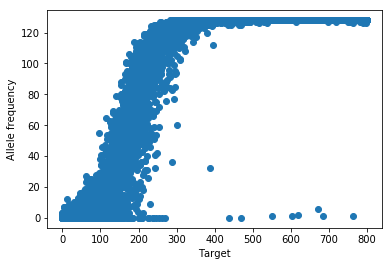

In [182]:
plt.scatter(mypop.target, freqs, marker='o')
plt.xlabel('Target')
plt.ylabel('Allele frequency')

In [132]:
mypop.majorminor()
#mypop.filter_freq(0.01)
mypop.sort('rows_freq')
mypop.sort('cols_freq')
mypop.resize((128, 128))
mypop.convert()
mypop.shuffle()

Converting to numpy array.
Converting to float32.
Converting to [0,1].
Flipping values.
A numpy array with dimensions (9612, 128, 128, 1) and target with length 9612 and 801 classes.


0

In [9]:
import _pickle as pickle

In [10]:
# to save, create folder
os.mkdir('/home/mfumagal/Data/ImaGene/Images1.Epoch1')

In [11]:
# save
with open('/home/mfumagal/Data/ImaGene/Images1.Epoch1/mypop_sortedrowscolsfreq','wb') as fp:
    pickle.dump(mypop, fp)

In [12]:
# to load:
with open('/home/mfumagal/Data/ImaGene/Images1.Epoch1/mypop_sortedrowscolsfreq','rb') as fp:
    mypop = pickle.load(fp)

In [ ]:
#mypop.majorminor()
#mypop.filter_freq(0.01)
mypop.sort('rows_distance_top')
mypop.sort('cols_distance_top')
mypop.resize((128, 128))
mypop.convert()
mypop.shuffle()

# save
with open('/home/mfumagal/Data/ImaGene/Images1.Epoch1/mypop_sortedrowscolsdist','wb') as fp:
    pickle.dump(mypop, fp)
    
# to load:
with open('/home/mfumagal/Data/ImaGene/Images1.Epoch1/mypop_sortedrowscolsdist','rb') as fp:
    mypop = pickle.load(fp)

In [ ]:
# to load:
with open('/home/mfumagal/Data/ImaGene/Images1.Epoch1/mypop_sortedrowscolsdist','rb') as fp:
    mypop = pickle.load(fp)

0


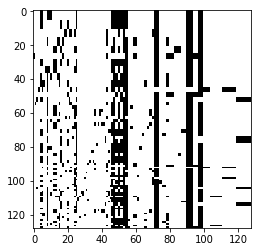

100


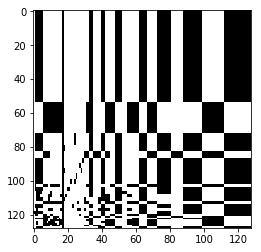

200


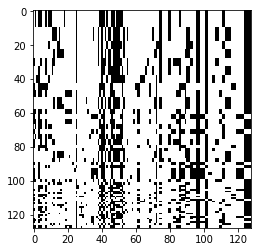

300


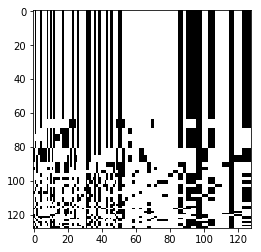

400


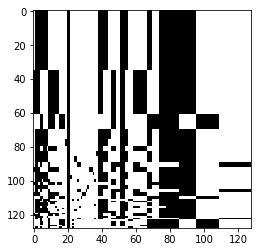

500


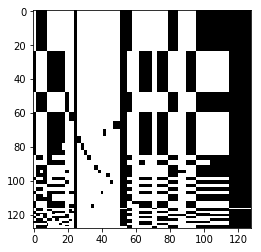

600


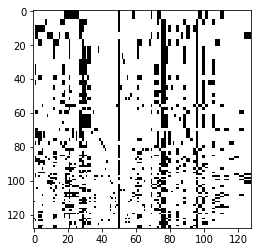

700


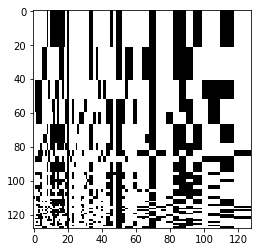

799


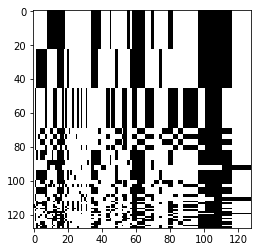

In [133]:
for sel in [0,100,200,300,400,500,600,700,799]:
    ind=np.where(mypop.target == sel)[0][2]
    print(sel)
    mypop.plot(ind)

In [134]:
mypop.set_classes(nr_classes=4)
print(mypop.classes)

[  0.         266.66666667 533.33333333 800.        ]


In [139]:
mypop.set_targets(wiggle=0, sd=0)
mypop.target

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       ...,
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0]])

In [157]:
freqs = np.zeros(len(mypop.data))
print(len(freqs))
for i in range(len(freqs)):
    print(i)
    freqs[i] = mypop.data[i][:,np.where(mypop.positions[i]==0.5)[0][0],0].sum()


9612
0
1


IndexError: index 0 is out of bounds for axis 0 with size 0

In [161]:
i=1
mypop.positions[i]
#mypop.data[i]#[:,np.where(mypop.positions[i]==0.5)[0][0],0].sum()

array([7.7000e-04, 3.3500e-03, 1.1300e-02, 1.7320e-02, 1.8040e-02,
       3.5420e-02, 4.9290e-02, 5.1440e-02, 5.2450e-02, 5.6960e-02,
       6.2760e-02, 6.6100e-02, 6.9100e-02, 7.4720e-02, 8.1870e-02,
       8.5170e-02, 1.0473e-01, 1.0514e-01, 1.1739e-01, 1.2402e-01,
       1.2413e-01, 1.2529e-01, 1.3213e-01, 1.3336e-01, 1.4190e-01,
       1.4227e-01, 1.5247e-01, 1.5323e-01, 1.5557e-01, 1.5595e-01,
       1.5854e-01, 1.6759e-01, 1.7663e-01, 1.8551e-01, 1.9017e-01,
       2.1241e-01, 2.3179e-01, 2.3888e-01, 2.4481e-01, 2.5826e-01,
       2.5982e-01, 2.7092e-01, 2.7506e-01, 2.7815e-01, 2.8093e-01,
       2.8452e-01, 2.8640e-01, 2.8823e-01, 2.9768e-01, 3.0169e-01,
       3.0474e-01, 3.0826e-01, 3.0891e-01, 3.1310e-01, 3.2349e-01,
       3.2620e-01, 3.4197e-01, 3.5441e-01, 3.6261e-01, 3.6440e-01,
       3.6797e-01, 3.7425e-01, 3.7595e-01, 3.7821e-01, 3.8481e-01,
       3.9001e-01, 3.9403e-01, 3.9425e-01, 4.0448e-01, 4.0460e-01,
       4.0956e-01, 4.1269e-01, 4.1520e-01, 4.2145e-01, 4.2189e

In [ ]:
mynet = ImaNet(mypop)

In [ ]:
model = models.Sequential([
                        layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same", input_shape=mynet.input_shape),
                        layers.MaxPooling2D(pool_size=(2,2)),
                        layers.Dropout(rate=0.5),
                        layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same", input_shape=mynet.input_shape),
                        layers.MaxPooling2D(pool_size=(2,2)),
                        layers.Dropout(rate=0.5),
                        layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same", input_shape=mynet.input_shape),
                        layers.MaxPooling2D(pool_size=(2,2)),
                        layers.Dropout(rate=0.5),
                        layers.Flatten(),
                        #layers.Dense(units=128, activation="relu"),
                        layers.Dense(units=mynet.output_shape, activation="softmax")])

model.compile(optimizer=optimizers.Adam(0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
mynet.net = model
#mynet.plot_net()

In [ ]:
mynet.train(epochs=50, batch_size=64)

In [ ]:
mynet.plot_train()

In [ ]:
mynet.test()

In [ ]:
mynet.plot_cm()

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
pred = np.argmax(mynet.net.predict(mynet.gene.data, batch_size=None), axis=1)
true = np.argmax(mynet.gene.target, axis=1)

In [ ]:
reg = LinearRegression().fit(true.reshape(-1,1), pred.reshape(-1,1))

In [ ]:
plt.scatter(true, pred , marker='o')
plt.title('Linear relationship between true and predicted labels')
plt.xlabel('True label')
plt.ylabel('Predicted label')